In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy.optimize
import time
import random
from matplotlib import collections  as mc
import networkx as nx
from scipy.spatial import distance
from sklearn.cluster import KMeans
import seaborn as sn

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 1 Simulation de graphes aléatoires: graphe par attachement préférentiel

## Question 1.1

In [3]:
def simuleGraphe(n):
    '''
Function that randomly creates the adjacency matrix of a graph of size n

Input:
    n: int, size of the wanted graph
    
Output:
    graphe: np.array of size n*n
    
    
    '''
    graphe1 = np.array([[1,1], [1,0]])
    graphe = graphe1
    for _ in range (n - 2):
        graphe = nextGraph(graphe)
        
    return graphe

def reshapeGraph(graphe):
    '''
Function that reshapes a graphe of size n to size n+1, with zeros in last row and column

Input:
    graphe: np.array of size n,n
    
Output:
    newMatrix: np.array of size n+1, n+1 with zeros on last row and column
    
    
    '''    
    n = graphe.shape[0]
    newMatrix = graphe.copy()
    lastRow = np.zeros((1,n))
    newMatrix = np.concatenate((newMatrix, lastRow), axis = 0)
    
    lastColumn = np.zeros((n+1,1))
    newMatrix = np.concatenate((newMatrix, lastColumn), axis = 1)
    
    return newMatrix

def degre(graphe, i):
    '''
Function that returns the degree of vertex in a graph described by its adjacency matrix

Input:
    graphe: np.array, adjacency matrix
    i: int, given vertex
    
Output:
    result: int, degree of  vertex i in graphe
    
    
    '''
    return graphe[i][:].sum()


def probabiliteSommet(graphe):
    '''
Function that returns, for each vertex, the probability that the next vertex in the graph would connect to it

Input:
    graphe: np.array, adjacency matrix
    
Output:
    result: list, list of probabilities
    
    
    '''
    n = graphe.shape[0]
    
    list_degres = []
    for i in range (n):
        list_degres.append(degre(graphe,i)/ (2 * n -1)) # On récupère les probabilités de chaque sommet
        
    return list_degres

def nextSommet(graphe):
    '''
Function that returns on which vertex the new vertex will link

Input:
    graphe: np.array, adjacency matrix
    
Output:
    l: int, refers to some vertex
    
    
    '''
    n = graphe.shape[0]
    list_degres = probabiliteSommet(graphe)

    for k in range(1, n):
        list_degres[k] = list_degres[k] + list_degres[k -1]

    alea = np.random.rand()
    list_degres = [0] + list_degres

    for l in range(n):
        if (list_degres[l] <= alea < list_degres[l+1]):
            return l

def nextGraph(graphe):
    '''
Function that creates a new adjacency matrix of size (n+1, n+1) with a new added vertex and edge

Input:
    graphe: np.array, adjacency matrix
    
Output:
    nextMatrix: np.array, adjacency matrix of size n+1
    
    
    '''
    n = graphe.shape[0]
    
    nextSommet_ = nextSommet(graphe)
    nextMatrix = reshapeGraph(graphe)
    
    nextMatrix[nextSommet_][n] = 1
    nextMatrix[n][nextSommet_] = 1
    
    return nextMatrix


In [4]:
simuleGraphe(10)

array([[1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Question 1.2

In [5]:
def degreGraph(graphe):
    '''
Function that returns, for a given graph, the degree of each vertex

Input:
    graphe: np.array, adjacency matrix
    
Output:
    result: list, list of degrees
    
    
    '''
    return  [degre(graphe,i) for i in range(graphe.shape[0]) ]

In [6]:
def simulation(sommet, N, n):
    '''
Function that returns, for a given vertex, its average degree across N randomly simulated graphs of size n

Input:
    sommet: int, vertex
    N: int, the number of repetitions we want to make
    n: int, the size of the graphs we want to take
    
Output:
    moyenne_degres_sommet: list, contains the average degree of the node. Size is 2n -1. Sum equals 1
    
    
    '''
    
    resultats_simulation = []
    for _ in range (N):
        resultats_simulation.append(degreGraph(simuleGraphe(n))) 
        
    degres_possibles = 2* n - 1
    degres_sommet = [resultats_simulation[k][sommet] for k in range (len(resultats_simulation))]
    moyenne_degres_sommet = [0] * degres_possibles
        
    for deg in degres_sommet:
        moyenne_degres_sommet[int(deg)] += 1
        
    moyenne_degres_sommet = np.dot(1/N, moyenne_degres_sommet)

    return moyenne_degres_sommet

In [7]:
def powerlaw(numberOfSimulations, sizeOfGraph):
    '''
Function that returns, for a random vertex, its degree distribution, for N graphs of size n

Input:
    numberOfSimulations: int, number of simulations
    sizeOfGraph: int, size of the graphs 
    
Output:
    result: tuple, contains parameters of the fitting curve
    
    '''
    sommet = np.random.randint(int(sizeOfGraph/10), int(sizeOfGraph/5))
    simul = simulation(sommet, numberOfSimulations, sizeOfGraph)
    
    ydata = simul[1:int((sizeOfGraph * 2 - 1)/5)]
    xdata = np.arange(1, int((sizeOfGraph * 2 - 1)/5))
    popt, pcov = scipy.optimize.curve_fit(f, xdata, ydata)
    
    plt.plot(simul[:int(sizeOfGraph/10)], label = 'P(degré de s = k) pour s = {}'.format(sommet))
    plt.plot(np.arange(int(sizeOfGraph/10)), f(np.arange(int(sizeOfGraph/10)), *popt), 'g--', label='fit: c=%5.3f, alpha=%5.3f' % tuple(popt))
    plt.xlabel('degré du sommet')
    plt.ylabel('probabilité que le sommet ait tel degré')
    plt.legend()
    
    return ('fit: c=%5.3f, alpha=%5.3f' % tuple(popt)), sommet
    
def f(x, c, alpha):
    return c * (x **(- alpha))

('fit: c=0.466, alpha=1.346', 29)

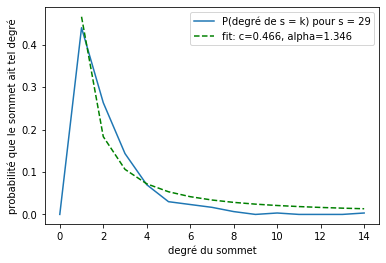

In [15]:
powerlaw(300, 150)

# Visualisation d'un graphe: un problème d'optimisation

## Question 2.1

In [16]:
def createPoints(n):
    """
Function that outputs n random points in [0,1]²

Input: 
    n: int, the number of points to plot

Output:
    X,Y: lists of the X and Y coordinates

    """

    X, Y = [], []
    for _ in range (n):
        X.append(random.random())
        Y.append(random.random())
        
    return X, Y

In [17]:
def grapheSimple(graphe_matrix, X, Y, iterations = 1):
    """
For a given graph matrix, and a set of coordinates, plots the graph nodes at the given coordinates

Input:
    graphe_matrix: numpy.array, value (i,j) = 1 if there is a vertex between nodes i and j. 0 otherwise
    X: list, the list of the X-coordinates of the points to plot
    Y: list, the list of the Y-coordinates of the points to plot

Output:
    Void
    Prints a matplotlib figure
    """
    n = graphe_matrix.shape[0]
    lines = []
    for i in range(n):
        for j in range(i):
            if (graphe_matrix[i][j] == 1.):
                lines.append([(X[i], Y[i]), (X[j], Y[j])])
                
    lc = mc.LineCollection(lines, colors= 'r', linewidths=1)
    fig, ax = plt.subplots(figsize = (10,7))
    plt.scatter(X,Y, marker = 'o', s = 20)
    for i,k in enumerate(np.arange(n)):
        ax.annotate(k, (X[i], Y[i]))
        
    ax.add_collection(lc)
    ax.margins(0.1)
    plt.title('Graphe de taille 10 dessiné avec des coordonnées aléatoires')

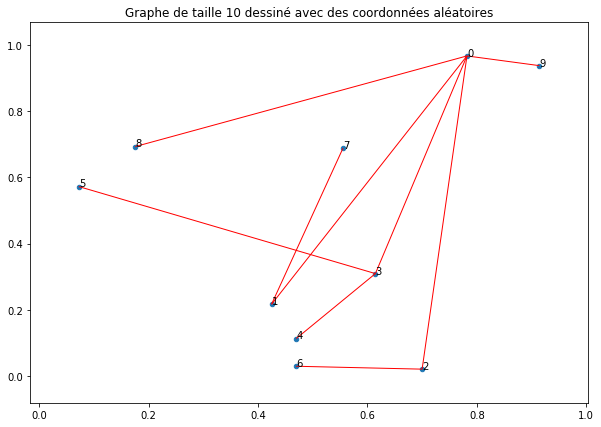

In [18]:
X,Y = createPoints(10)
grapheSimple(simuleGraphe(10), X, Y)

In [19]:
def create_Graph_aleatoire(taille):
    """
Randomly creates and plots a graph of size 'taille', using the Networkx library

Input:
    taille: int, the size of the wanted graph
    
Output:
    G: networkx.Graph of size taille
    Plots G in a matplotlib figure
    """
    
    G = nx.Graph()
    G.add_nodes_from(np.arange(0,taille))
    data = simuleGraphe(taille)
    for i in range(taille):
        for j in range(i):
            if (data[i][j] == 1):
                G.add_edge(i,j)
    nx.draw(G, with_labels = True)
    return G


def create_Graph(matrice):
    """
Creates and plots a graph using its Adjacency matrix, using the Networkx library

Input:
    matrice: numpy.array, the Adjacency matrix
    
Output:
    G: networkx.Graph where nodes follow the adjacency matrix constraints
    """
    G = nx.Graph()
    G.add_nodes_from(np.arange(0,matrice.shape[0]))
    for i in range(matrice.shape[0]):
        for j in range(i):
            if (matrice[i][j] == 1):
                G.add_edge(i,j)
#     nx.draw(G, with_labels = True)
    return G



In [20]:
def get_Graph_max_length(G):
    """
Gets the maximum vertices length in a given graph G

Input:
    G: Networkx.graph
    
Output:
    integer: maximum distance in G
    """
    
    path = list(nx.shortest_path_length(G))
    lengths = [max(path[x][1].values()) for x in range (len(path))]
    return max(lengths)

In [21]:
def Distance(G,i,j):
    """
For a graph G, computes the distance between nodes i and j

Input:
    G: networkx.graph
    i,j: int
    
Output:
    int: distance between i and j
    """
    
    return nx.shortest_path_length(G,i,j)

In [22]:
def Energie(X, Y, G):
    """
As introduced in the project questions, this computes the Energy associated to a graph and a set of points

Input:
    X,Y: numpy.array or array-like, coordinates of you points
    G: networkx.graph
    
Output:
    S: float, computed as defined in the project 
    """
    max_length = get_Graph_max_length(G)
    n = len(X)
    S = 0
    for i in range (n):
        for j in range (n):
            if (i !=j):
                D_etoile = Distance(G,i,j) / max_length
                S += (((distance.euclidean([X[i], Y[i]], [X[j], Y[j]])/np.sqrt(2)) - D_etoile) ** 2 )/ (D_etoile**2)
    return S


Text(0.5, 1.0, 'Randomly created graph using the create_Graph method')

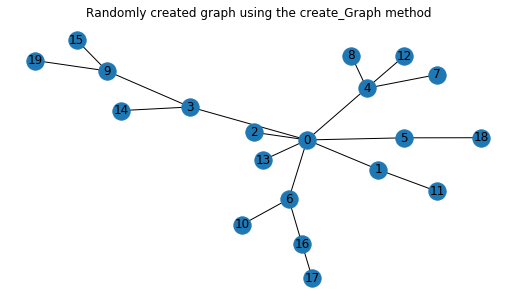

In [44]:
X, Y = createPoints(20)
datatest = simuleGraphe(20)
testgraph = create_Graph(datatest)
fig, ax = plt.subplots(figsize = (9,5))
nx.draw(testgraph, with_labels = True, ax = ax)
plt.title('Randomly created graph using the create_Graph method')

In [17]:
def gradientEnergie(X,Y,G):
    """
Computes the gradient of the Energy function for a graph G and a set of points X,Y

Input:
    X,Y: numpy.array or array-like, coordinates of you points
    G: networkx.graph
    
Output:
    LX, LY: gradient following X and Y of the Energy function
    """
    
    max_length = get_Graph_max_length(G)
    n = len(X)
    LX = []
    LY = []
    for k in range(n):
        Xk = 0
        Yk = 0
        for i in range(n):
            if (i !=k):
                D_etoile = Distance(G,i,k) / max_length
                Xk += ((X[k] - X[i])- D_etoile * (X[k] - X[i]) /( np.sqrt(2) * distance.euclidean([X[i], Y[i]], [X[k], Y[k]])) )/ (D_etoile ** 2)
                Yk += (Y[k] - Y[i] - D_etoile *(Y[k] - Y[i] )/( np.sqrt(2) * distance.euclidean([X[i], Y[i]], [X[k], Y[k]]))) / (D_etoile ** 2)
        LX.append(Xk)
        LY.append(Yk)
        
    return LX,LY
        
    

In [18]:
def GPF(Graphe_matrix, tol, eta, itermax):
    """
Correctly plots a graph accordingly to the adjacency matrix, by using a gradient descent with constant step method

Input:
    Graphe_matrix: numpy.array, your adjacency matrix
    tol: float, tolerance level in our gradient descent
    alpha: step used for each iteration
    
    """
    X,Y = createPoints(Graphe_matrix.shape[0])
    G = create_Graph(Graphe_matrix)
    E = Energie(X, Y, G)
    iterations = 0
    LX, LY = gradientEnergie(X,Y,G)
    grad = max(max(np.abs(LX)), max(np.abs(LY)))
    
#     grapheSimple(Graphe_matrix, X, Y)
    
    while (grad > tol):
        if (iterations > itermax):
            print('Max iterations overflow')
            return X,Y
        LX,LY = gradientEnergie(X,Y,G)
        X = X - np.dot(eta, LX)
        Y = Y - np.dot(eta, LY)
        for i in range (len(X)):
            if (X[i]<0): X[i] = 0
            if (X[i]>1): X[i] = 1            
            if (Y[i]<0): Y[i] = 0
            if (Y[i]>1): Y[i] = 1
        E = Energie(X, Y, G)
        iterations +=1
        grad = max(max(np.abs(LX)), max(np.abs(LY)))
#         if (iterations % 50 == 0):
#             grapheSimple(Graphe_matrix, X, Y, iterations = iterations)
#     print('gradient final = {}'.format(grad))
#     print('iterations = {}'.format(iterations))
#     grapheSimple(Graphe_matrix, X, Y, iterations = iterations)
    return X,Y

In [19]:
def GPV(Graphe_matrix, tol, eta0, itermax):
    """
Plots a graph accordingly to the adjacency matrix, by using a gradient descent with non-constant step method. Step is normalised
and divided by log(number of iterations)

Input:
    Graphe_matrix: numpy.array, your adjacency matrix
    tol: float, tolerance level in our gradient descent
    alpha: step used for each iteration
    
    """
    
#Initialisation
    X,Y = createPoints(Graphe_matrix.shape[0]) #On prend un jeu de points aléatoires
    G = create_Graph(Graphe_matrix) #On crée notre graphe à partir de la matrice d'adjacence
    LX, LY = gradientEnergie(X,Y,G) #On calcule son gradient
    
    grad = max(max(np.abs(LX)), max(np.abs(LY))) #Pour la norme, on prend le max en valeur absolue du vecteur de taille 2n

    iterations = 0
    grapheSimple(Graphe_matrix, X, Y)
    
    while (grad > tol):
        E = Energie(X, Y, G) #On calcule son énergie
#         print('grad = {} E= {}'.format(grad,E))
        eta = eta0
        if (iterations > itermax):    
            print('Max iterations overflow')
            grapheSimple(Graphe_matrix, X, Y, iterations)
            return X,Y


        LX,LY = gradientEnergie(X,Y,G)
        grad = max(max(np.abs(LX)), max(np.abs(LY)))
        eta = eta/np.log(iterations + 2)
        eta = eta/grad
        X = X - np.dot(eta, LX)
        Y = Y - np.dot(eta, LY)
              
        iterations +=1
        
        if (iterations % 100 == 0):
            grapheSimple(Graphe_matrix, X, Y, iterations)

    grapheSimple(Graphe_matrix, X, Y, iterations)
    print('gradient final = {}'.format(grad))
    print('iterations = {}'.format(iterations))
    return X,Y

## Une variante: le delta-attachement préférentiel

In [20]:
def simuleGraphe_delta(n, delta):
    graphe1 = np.array([[1,1], [1,0]])
    graphe = graphe1
    for _ in range (n - 2):
        graphe = nextGraph_delta(graphe, delta)
        
    return graphe


def degre(graphe, i):
    return graphe[i][:].sum()

def probabiliteSommet_delta(graphe, delta):
    n = graphe.shape[0]
    
    list_degres = []
    for i in range (n):
        list_degres.append((degre(graphe,i) + delta)/ (2 * n + (n*delta) -1)) # On récupère les probabilités de chaque sommet
        
    return list_degres

def nextSommet_delta(graphe, delta):
    n = graphe.shape[0]
    list_degres = probabiliteSommet_delta(graphe, delta)

    for k in range(1, n):
        list_degres[k] = list_degres[k] + list_degres[k -1]

    alea = np.random.rand()
    list_degres = [0] + list_degres

    for l in range(n):
        if (list_degres[l] <= alea < list_degres[l+1]):
            return l

        
def nextGraph_delta(graphe, delta):
    n = graphe.shape[0]
    
    nextSommet_ = nextSommet_delta(graphe, delta)
    nextMatrix = reshapeGraph(graphe)
    
    nextMatrix[nextSommet_][n] = 1
    nextMatrix[n][nextSommet_] = 1
    
    return nextMatrix

In [21]:
def plot_graphe_delta_variable(taille, deltamin, deltamax, nombre):
#     petits_deltas = np.linspace(deltamin, deltamax, nombre)
    petits_deltas = [-0.99, -0.5, -0.2, -0.1, 0, 1, 5, 10, 20]
    fig, ax = plt.subplots(3,3,figsize=(15,15))
    for i, delta in enumerate(petits_deltas):
        graph_delta = create_Graph(simuleGraphe_delta(taille, delta)) 
        k = i //3
        j = i % 3
        nx.draw(graph_delta, with_labels = True, ax = ax[k][j])
        ax[k, j].set_title('Graphe avec delta = {}'.format(delta))

# 3 Clustering et détection de communautés : utilisation de la décomposition spectrale

## Question 3.1.

In [45]:
def SpectralClusteringAlgorithm(similarityMatrix, k, epsilon = 2):
    """
Unnormalised Spectral Clustering algorithm

Input:
    similarityMatrix: np.array, a given similarity matrix
    k: int, the number of clusters to create
    
    """    
    n = similarityMatrix.shape[0]
    weightMatrix = makeAdjacencyMatrixEpsilon (similarityMatrix, epsilon)
    Degrees = degreeMatrix(weightMatrix)
    L = Degrees - weightMatrix
    w, v = np.linalg.eig(L)
    v = np.array([v[:,i] for i in range(len(w))])
    idx = w.argsort()[::-1]
    w = w[idx]
    v = v[idx]
    w= w[::-1]
    v = v[::-1]
    v = np.array(v)
    v = v.transpose()
    v = v[:,:k]

    T = []
    for j in range(n):
        T.append(v[j][:])
    T = np.real(T)
    kmeans = KMeans(n_clusters= k, random_state=0).fit_predict(T)
    
    res = {}
    for i in range (k):
        res[i] = []
    for i, val in enumerate(kmeans):
        res.update(val = [res[val].append(i)])
    return res

def makeAdjacencyMatrixEpsilon(similarityMatrix, epsilon):
    n = similarityMatrix.shape[0]
    S = np.zeros((n,n))
    for i in range (n):
        for j in range (n):
            if (0. < similarityMatrix[i][j] < epsilon):
                S[i][j] = 1
          
    return S

def degreeMatrix(adjacencyMatrix):
    n = adjacencyMatrix.shape[0]
    S = np.zeros((n,n))
    
    for i in range(n):
        S[i][i] = degre(adjacencyMatrix, i)
    return S

In [23]:
matoche = simuleGraphe_delta(20, 2)

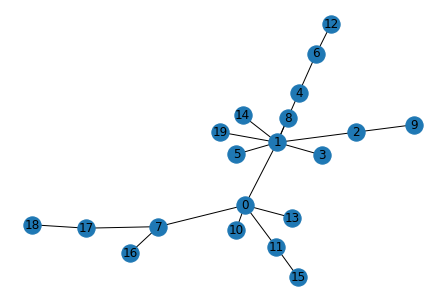

In [24]:
nx.draw(create_Graph(matoche), with_labels = True)

In [25]:
def question31(n, delta, k, ax):
    matrice = simuleGraphe_delta(n, delta)
    clusters = SpectralClusteringAlgorithm(matrice, k)
    
    X, Y = GPF(matrice, 0.01, 0.001, 500)
    n = matrice.shape[0]
    colors = ['red', 'yellow', 'blue', 'green', 'brown']
    markers = ['v', '*', 'X', 'o', 's']
    for i in range(n):
        for j in range(i):
            if (matrice[i][j] == 1.):
                if ((getClass(clusters, i) == getClass(clusters,j))):
                    ax.plot([X[i], X[j]], [Y[i], Y[j]], colors[getClass(clusters, i)])
                else:
                    ax.plot([X[i], X[j]], [Y[i], Y[j]], 'black', alpha=0.5)
    
    for i,l in enumerate(np.arange(n)):
        ax.annotate(l, (X[i], Y[i]))
        
#     ax.title('Séparation en k = {} clusters, pour n = {} points et delta = {}'.format(k, n, delta))
#     ax.scatter(X,Y, marker = 'o', s = 20)  
    ax.margins(0.1)


In [26]:
def outputQ31():
    delta = 5
    fig, ax = plt.subplots(3,4, figsize = (20,20))
    for i2, n in enumerate([10, 20, 30]):
        for i3, k in enumerate([2, 3 ,4, 5]):
            question31(n,delta,k, ax[i2][i3])
            ax[i2, i3].set_title('k = {} clusters, n = {} points et delta = {}'.format(k, n, delta))

## Question 3.2.

In [27]:
def StochasticBlockModel(n, K, E, q):
    # E liste de k sous-listes qui correspondent aux partitions
    # q matrice de taille (K,K)
    matrix = np.zeros((n,n))
    for i in range (n):
        r = getClass(E,i)
        for j in range (n):
            s = getClass(E,j)
            alea = random.random()
            if (alea < q[r][s]):
                matrix[i][j] = 1
                
    return matrix



def getClass(E,i):
    for k in range (len(E)):
        if (i in E[k]):
            return k
    return False


def createClass(K, n):
    res = {}
    for i in range (K):
        res[i] = []
    for i in range(n):
        x = random.randint(0,K-1)
        res[x] = res[x] + [i]
    return res

In [89]:
def performanceSpectralClustering(n, K, alpha):
    q = np.random.rand(K,K)
    q = np.dot(0.8, np.eye(K)) + np.dot(alpha,np.ones((K,K)) - np.eye(K))
    print(q)
    E = createClass(K, n)
    SBM = StochasticBlockModel(n, K, E, q)
    X, Y = GPF(SBM, 0.01, 0.005, 100)
    SBM_graph = createClusteredGraph(SBM, E, X,Y)
    predicted_clusters = SpectralClusteringAlgorithm(SBM, K)
    predicted_clusters.pop('val', None)
    predicted_graph = createClusteredGraph(SBM, predicted_clusters, X,Y)

    print('Initial Clusters: {}'.format(E))
    print('Predicted clusters: {}'.format(predicted_clusters))
    
    if (clustersMatch == True):
        return ('Predicted clusters match perfectly')
    else:
        return ('No perfect match')
    
    
def createClusteredGraph(matrice, clusters, X,Y):    
#     X, Y = GPF(matrice, 0.01, 0.005, 50)
    fig, ax = plt.subplots(figsize = (15,10))
    n = matrice.shape[0]
    colors = ['red', 'yellow', 'blue', 'green', 'brown']
    markers = ['v', '*', 'X', 'o', 's']
    for i in range(n):
        for j in range(i):
            if (matrice[i][j] == 1.):
                if ((getClass(clusters, i) == getClass(clusters,j))):
                    plt.plot([X[i], X[j]], [Y[i], Y[j]], colors[getClass(clusters, i)])
                else:
                    plt.plot([X[i], X[j]], [Y[i], Y[j]], 'black', alpha=0.2)
    
    for i,k in enumerate(np.arange(n)):
        ax.annotate(k, (X[i], Y[i]))
    plt.scatter(X,Y, marker = 'o', s = 20)  
    ax.margins(0.1)

# nx.draw(create_Graph(SBM), with_labels = True)

In [90]:
def clustersMatch(Initial_clusters, Predicted_clusters):
    for i in Initial_clusters:
        if (hasMatch(Initial_clusters[i], Predicted_clusters) == False):
            return False
    return True
        
def hasMatch(points, clusters):
    if points in clusters.values():
            return True
    return False

[[0.8 0.2 0.2 0.2]
 [0.2 0.8 0.2 0.2]
 [0.2 0.2 0.8 0.2]
 [0.2 0.2 0.2 0.8]]
Max iterations overflow
Initial Clusters: {0: [3, 7, 11, 16, 25, 30, 31, 33, 35, 38, 44, 48, 56, 60, 61, 67, 69, 76], 1: [1, 4, 5, 17, 28, 36, 41, 42, 52, 53, 55, 58, 65], 2: [2, 6, 8, 10, 21, 22, 24, 29, 37, 43, 45, 46, 50, 51, 54, 57, 70, 71, 75, 77], 3: [0, 9, 12, 13, 14, 15, 18, 19, 20, 23, 26, 27, 32, 34, 39, 40, 47, 49, 59, 62, 63, 64, 66, 68, 72, 73, 74, 78, 79]}
Predicted clusters: {0: [0, 9, 12, 13, 14, 15, 17, 18, 19, 20, 23, 26, 27, 32, 34, 39, 40, 47, 49, 59, 62, 63, 64, 66, 68, 72, 73, 74, 78, 79], 1: [1, 2, 4, 5, 6, 8, 10, 21, 22, 24, 28, 29, 36, 37, 41, 42, 43, 45, 46, 50, 51, 52, 54, 55, 57, 58, 65, 70, 71, 75, 77], 2: [53], 3: [3, 7, 11, 16, 25, 30, 31, 33, 35, 38, 44, 48, 56, 60, 61, 67, 69, 76]}


'No perfect match'

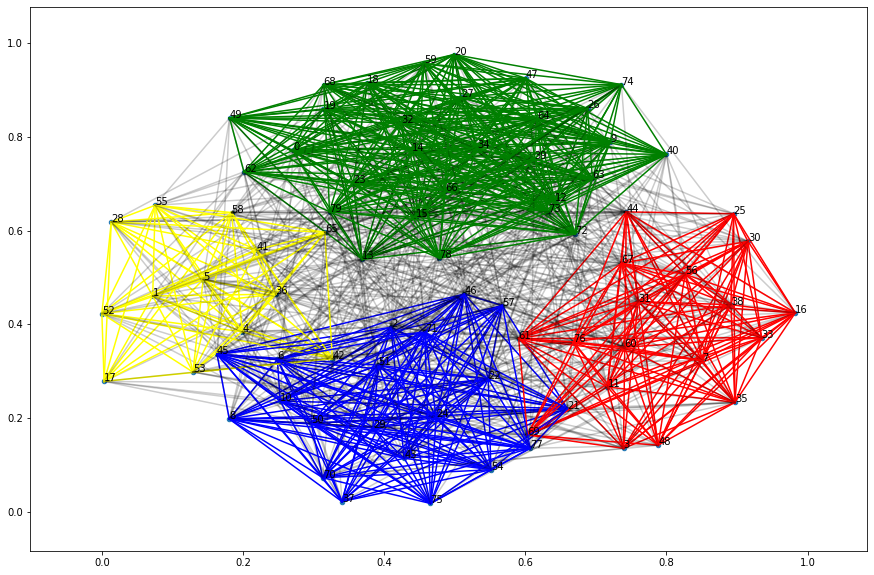

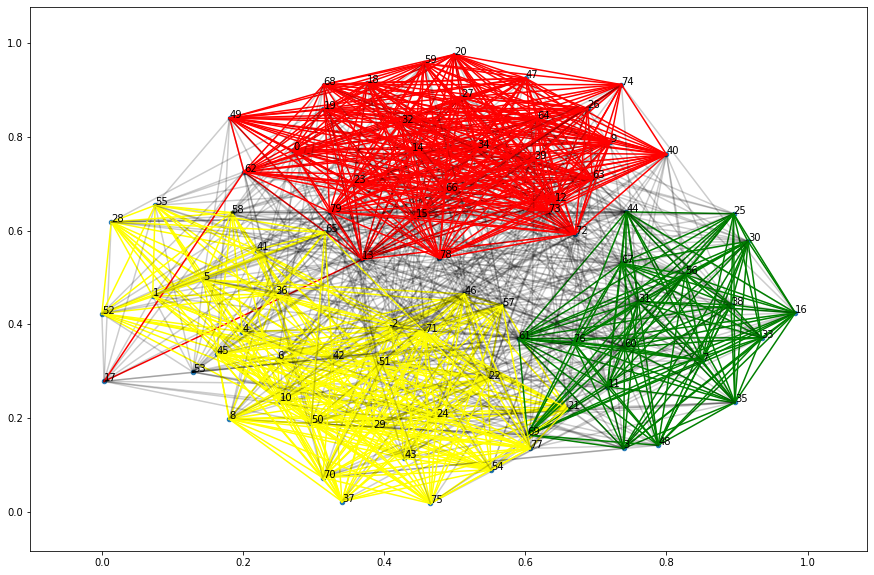

In [111]:
performanceSpectralClustering(80, 4, alpha = 0.2)

False


# 4 Popularité dans un graphe : une approche par valeurs propres (PageRank)

In [120]:
def renormalizeAdjacencyMatrix(adjacencyMatrix):
    n = adjacencyMatrix.shape[0]
    T = np.zeros((n,n))
    for i in range(n):
        col_i = sum(adjacencyMatrix[i,:])
        for j in range(n):
            T[i][j] = adjacencyMatrix[i][j] / col_i
    return T


def Pepsilon (adjacencyMatrix, epsilon):
    n= adjacencyMatrix.shape[0]
    Atilde = renormalizeAdjacencyMatrix(adjacencyMatrix)
    P = np.dot((1 - epsilon), Atilde)
#     print(P)
    P += np.dot(epsilon/n, np.ones((n,n)))
    return P

In [121]:
def getScore(adjacencyMatrix, epsilon):
    Peps_ = Pepsilon(adjacencyMatrix, epsilon)
    Peps_ = Peps_.transpose()
    w,v = np.linalg.eig(Peps_)
    w = [round(x,2) for x in w]
    for i,x in enumerate(w):
        if (x == 1.0):
            res =  v[:,i]
            break
    lamda = 1/sum(res)
    res = np.dot(lamda, res)
    return res

In [122]:
testMatrix = matoche
dong = getScore(testMatrix, 0.15)

In [123]:
dong

array([0.1342869 +0.j, 0.18695475+0.j, 0.05282026+0.j, 0.02736394+0.j,
       0.05102449+0.j, 0.02736394+0.j, 0.05567187+0.j, 0.07382996+0.j,
       0.02736394+0.j, 0.02994861+0.j, 0.02652398+0.j, 0.05150525+0.j,
       0.03116054+0.j, 0.02652398+0.j, 0.02736394+0.j, 0.02938973+0.j,
       0.02841849+0.j, 0.05447121+0.j, 0.03065027+0.j, 0.02736394+0.j])

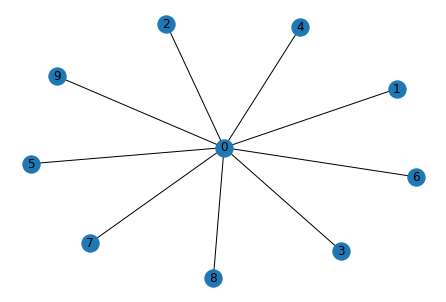

In [124]:
matoche = simuleGraphe_delta(10, -0.99)
nx.draw(create_Graph(matoche), with_labels = True)

In [162]:
def simuleGrapheOriente(n):
    graphe1 = np.array([[1,1], [0,0]])
    graphe = graphe1
    for _ in range (n - 2):
        graphe = nextGraphOriente(graphe)
        
    return graphe


def nextGraphOriente(graphe):
    n = graphe.shape[0]
    
    nextSommet_ = nextSommetOriente(graphe)
    nextMatrix = reshapeGraph(graphe)
    
    nextMatrix[nextSommet_][n] = 1
    
    return nextMatrix


def degreOriente(graphe, i):
    if (i == 0):
        return graphe[0][:].sum() + 1
    
    else:
        return (graphe[i,:].sum() + graphe[:,i].sum())
    

def probabiliteSommetOriente(graphe):
    n = graphe.shape[0]
    
    list_degres = []
    for i in range (n):
        list_degres.append(degreOriente(graphe,i)/ (2 * n -1)) # On récupère les probabilités de chaque sommet
        
    return list_degres

def nextSommetOriente(graphe):
    n = graphe.shape[0]
    list_degres = probabiliteSommetOriente(graphe)

    for k in range(1, n):
        list_degres[k] = list_degres[k] + list_degres[k -1]

    alea = np.random.rand()
    list_degres = [0] + list_degres

    for l in range(n):
        if (list_degres[l] <= alea < list_degres[l+1]):
            return l


In [184]:
bab = np.array([[1., 0., 1., 1., 0.],
               [1., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 1.],
               [0., 0., 0., 0., 0.]])
bab
nextSommetOriente(bab)

0

In [164]:
for i in range (5):
    print(degreOriente(bab, i))

4.0
1.0
1.0
2.0
1.0


In [186]:
def create_GraphOriente(matrice):
    """
Creates and plots a graph using its Adjacency matrix, using the Networkx library

Input:
    matrice: numpy.array, the Adjacency matrix
    
Output:
    G: networkx.Graph where nodes follow the adjacency matrix constraints
    """
    G = nx.DiGraph()
    G.add_nodes_from(np.arange(0,matrice.shape[0]))
    for i in range(matrice.shape[0]):
        for j in range(matrice.shape[0]):
            if (matrice[i][j] == 1):
                G.add_edge(j,i)
    nx.draw(G, with_labels = True)
    return G


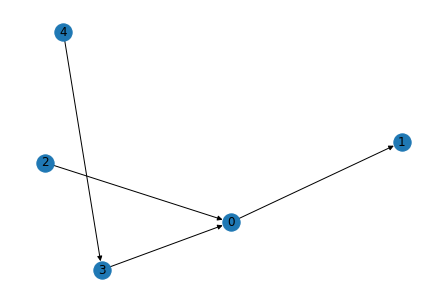

In [187]:
create_GraphOriente(bab)

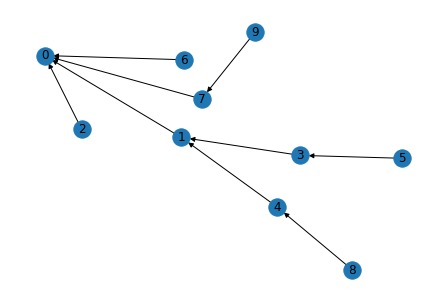

In [217]:
bab = simuleGrapheOriente(10)
create_GraphOriente(bab)

In [226]:
bab2 = bab + bab.transpose()
bab2[0][0] -= 1
bab2

array([[1., 1., 1., 0., 0., 0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [282]:
[round(x, 5) for x in getScore(bab2, 0.95)]

[0.10992,
 0.10118,
 0.0961,
 0.10156,
 0.10156,
 0.09754,
 0.0961,
 0.10098,
 0.09754,
 0.09752]

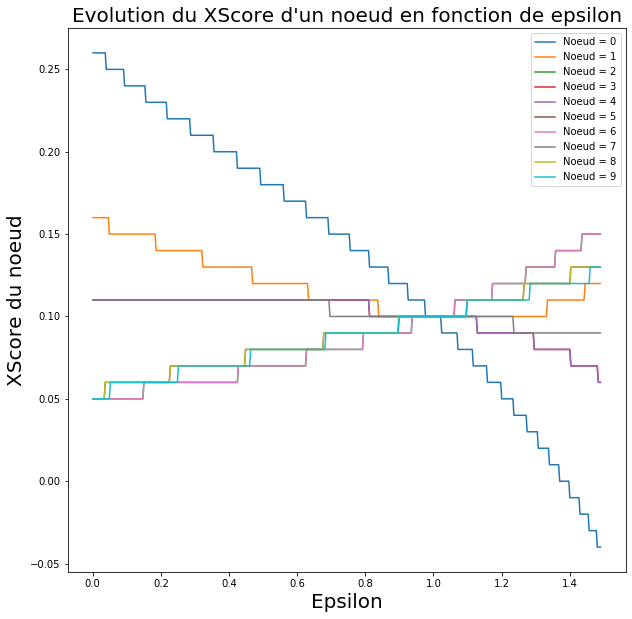

In [285]:
fig, ax = plt.subplots(figsize = (10,10))
epsilons = np.linspace(0.001, 1.49, 500)
mat = []
for eps in epsilons:
    res_eps = [round(x, 2) for x in getScore(bab2, eps)]
    mat.append(res_eps)
#     plt.plot(np.arange(0,10), res_eps)
# sn.kdeplot(res_eps, shade = False, ax = ax, legend ='Epsilon = {}'.format(eps) )
#     plt.legend('Epsilon = {}'.format(eps))
mat = np.array(mat)
mat = mat.transpose()
for i in range(mat.shape[0]):
    plt.plot(epsilons, mat[i], label = 'Noeud = {}'.format(i))
#     plt.legend = ('Degre = {}'.format(i))
plt.xlabel('Epsilon', size = 20)
plt.ylabel('XScore du noeud', size = 20)
plt.title( "Evolution du XScore d'un noeud en fonction de epsilon", size = 20 )
ax.legend()